<a href="https://colab.research.google.com/github/JulienGremillot/codelab_machine_learning/blob/main/Codelab_Classification_d'images_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On récupère le jeu de données "[Hotdog NotHotdog](https://www.kaggle.com/yashvrdnjain/hotdognothotdog)", disponible sur Kaggle ou sur mon drive à l'URL précisée dans le code.

In [1]:
import requests
from tqdm import tqdm
URL = "https://drive.google.com/uc?export=download"
id = "1pPl16WK_txBH-STO5v9sTbP6xfuxqbin"

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)
                    bar.update(CHUNK_SIZE)

session = requests.Session()
response = session.get(URL, params = { 'id' : id }, stream = True)
token = get_confirm_token(response)

if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)

save_response_content(response, "hotdog-nothotdog.zip")    

166MB [00:02, 73.2MB/s]


On décompresse le fichier ZIP

In [2]:
dataset_dir = "hotdog-nothotdog"
width, height = 224, 224
import zipfile
with zipfile.ZipFile('hotdog-nothotdog.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

On affiche quelques images du dataset

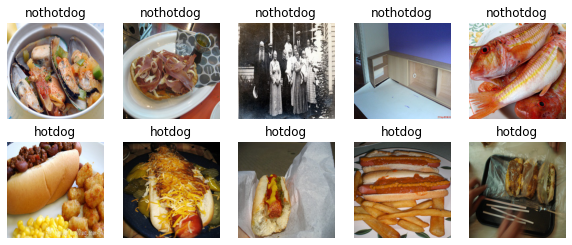

In [3]:
# Lecture des images du dataset
import os
from PIL import Image
import matplotlib.pyplot as plt

train_dir = os.path.join(dataset_dir, 'train')
plt.figure(figsize=(10,4))
i = 1
for sub_dir in os.listdir(train_dir):
    sub_dir_images = os.listdir(os.path.join(train_dir, sub_dir))
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 10 and j < 5:
            image = os.path.join(train_dir, sub_dir, sub_dir_image)
            img = Image.open(image) 
            img_resized = img.resize((width, height))
            plt.subplot(2, 5, i)
            plt.axis('off')
            plt.title(sub_dir)
            plt.imshow(img_resized)
            i = i + 1
            j = j + 1
plt.show()

On réalise un split 80% / 20% pour les jeux d'entrainement et de validation.

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory
batch_size = 32
train_ds = image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_ds = image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['hotdog', 'nothotdog']


L'objet train_ds permet de découper le jeu de données en batchs de 32 images.

In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [7]:
img_shape = image_batch[0].shape
num_classes = len(class_names)
print("Dimensions de l'image :", img_shape)
print("Nombre de classes de sortie :", num_classes)

Dimensions de l'image : (224, 224, 3)
Nombre de classes de sortie : 2


In [8]:
import tensorflow as tf

nb_epochs = 5
print("Nombre d'epochs pour l'entrainement :", nb_epochs)

model = tf.keras.applications.vgg16.VGG16(
        include_top=False, input_shape=(height, width, 3))
model.trainable = False

flat1 = tf.keras.layers.Flatten()(model.layers[-1].output)
class1 = tf.keras.layers.Dense(128, activation='relu')(flat1)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(class1)

model = tf.keras.models.Model(inputs=model.inputs, outputs=output)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

Nombre d'epochs pour l'entrainement : 5
58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                      

In [9]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=nb_epochs
)

Epoch 1/5
75/75 [==============================] - 1345s 18s/step - loss: 3.8444 - accuracy: 0.6896 - val_loss: 0.7106 - val_accuracy: 0.8283
Epoch 2/5
75/75 [==============================] - 1345s 18s/step - loss: 0.3493 - accuracy: 0.8708 - val_loss: 0.4577 - val_accuracy: 0.8367
Epoch 3/5
75/75 [==============================] - 1346s 18s/step - loss: 0.1654 - accuracy: 0.9342 - val_loss: 0.4207 - val_accuracy: 0.8550
Epoch 4/5
75/75 [==============================] - 1341s 18s/step - loss: 0.0541 - accuracy: 0.9800 - val_loss: 0.6069 - val_accuracy: 0.8617
Epoch 5/5
75/75 [==============================] - 1342s 18s/step - loss: 0.0193 - accuracy: 0.9892 - val_loss: 0.6433 - val_accuracy: 0.8533


In [8]:
import matplotlib.pyplot as plt

def show_perfs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

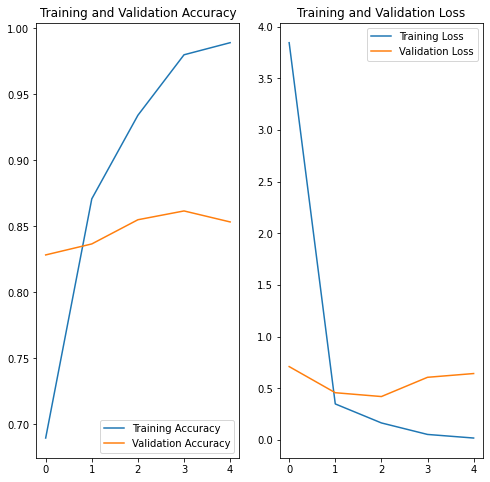

In [11]:
show_perfs(history, nb_epochs)

In [10]:
import numpy as np

def get_prediction(img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  # print(img_array.shape)
  img_batch = np.expand_dims(img_array, axis=0)  # batch d'1 seule image
  # print(img_batch.shape)
  prediction = model.predict(img_batch)
  # print(prediction)  # vecteur des probabilités par classe
  top_indice = prediction[0].argsort()[-1:][0]
  result = class_names[top_indice]
  return(result)

def test_model(model):
  test_dir = os.path.join(dataset_dir, 'test')
  plt.figure(figsize=(16, 8))
  i = 1
  j = 0
  oks = 0
  kos = 0
  for sub_dir in os.listdir(test_dir):
      hotdog_images = os.listdir(os.path.join(test_dir, sub_dir))
      for hotdog_image in hotdog_images:
          if i <= 5:
              img_path = os.path.join(test_dir, sub_dir, hotdog_image)
              img = Image.open(img_path)
              img_resized = img.resize((width, height))
              plt.subplot(2, 5, i + j * 5)
              plt.axis('off')
              prediction = get_prediction(img_resized)
              title = sub_dir + '\n> ' + prediction
              if sub_dir == prediction:
                title += " OK"
                oks += 1
              else:
                title += " KO"
                kos += 1
              plt.title(title)
              plt.imshow(img_resized)
              i += 1
      i = 1
      j += 1
  plt.show()
  print("\nOKs :", oks, "KOs :", kos, 
        "Pourcentage OK :", round(oks * 100 / (oks + kos)), "%")
  

In [ ]:
test_model(model)

C'est beaucoup mieux que notre modèle entrainé "from scratch" ! On peut maintenant essayer en partant d'autres modèles pré-entrainés :

*   ResNet50
*   InceptionV3
*   Xception
*   EfficientNet (EfficientNetB0)

Une fois qu'on a trouvé le meilleur modèle, on peut encore l'optimiser !

In [13]:
def model_builder(hp):

    # on cherche à optimiser la couche Dense
    hp_units = hp.Int('units', min_value=256, max_value=2048, step=256)

    # on cherche à optimiser la compilation du modèle
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5,
                                max_value=1e-3, sampling='LOG', default=1e-3)

    model = tf.keras.applications.EfficientNetB0(include_top=False, 
                              weights='imagenet',
                              input_shape=(height, width, 3),
                              classes=num_classes)
    model.trainable = False
    flat1 = tf.keras.layers.Flatten()(model.layers[-1].output)
    class1 = tf.keras.layers.Dense(hp_units, activation='relu')(flat1)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(class1)
    model = tf.keras.models.Model(inputs=model.inputs, outputs=output)
    model.summary()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [14]:
!pip install -q -U keras-tuner
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner',
                     project_name='dogs',
                     overwrite = True)

     |████████████████████████████████| 98 kB 3.9 MB/s 
16719872/16705208 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                      

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
img_train = None
label_train = None
for image_batch, labels_batch in tqdm(train_ds):
    if img_train == None:
        img_train = image_batch
        label_train = labels_batch
    else:
        img_train = tf.concat(axis=0, values = [img_train, image_batch])
        label_train = tf.concat(axis=0, values = [label_train, labels_batch])
  
print("img_train:", img_train.shape)
print("label_train:", label_train.shape)

100%|██████████| 75/75 [00:44<00:00,  1.67it/s]

img_train: (2400, 224, 224, 3)
label_train: (2400,)


In [17]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 19m 46s]
val_accuracy: 0.956250011920929

Best val_accuracy So Far: 0.9624999761581421
Total elapsed time: 04h 57m 20s
INFO:tensorflow:Oracle triggered exit


In [18]:
best_hps.values

{'learning_rate': 9.136024232442206e-05,
 'tuner/bracket': 1,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/round': 1,
 'tuner/trial_id': 'e38029de69b73d307ef383494a0e03af',
 'units': 768}

In [11]:
import tensorflow as tf

model = tf.keras.applications.EfficientNetB0(include_top=False, 
                              weights='imagenet',
                              input_shape=(height, width, 3),
                              classes=num_classes)
model.trainable = False
flat1 = tf.keras.layers.Flatten()(model.layers[-1].output)
class1 = tf.keras.layers.Dense(768, activation='relu')(flat1)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(class1)
model = tf.keras.models.Model(inputs=model.inputs, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(9.136024232442206e-05),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

16719872/16705208 [==============================] - 0s 0us/step


In [13]:
nb_epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=nb_epochs
)

Epoch 1/5
75/75 [==============================] - 187s 2s/step - loss: 0.3177 - accuracy: 0.9071 - val_loss: 0.2453 - val_accuracy: 0.9267
Epoch 2/5
75/75 [==============================] - 159s 2s/step - loss: 0.0486 - accuracy: 0.9821 - val_loss: 0.2345 - val_accuracy: 0.9367
Epoch 3/5
75/75 [==============================] - 170s 2s/step - loss: 0.0081 - accuracy: 0.9971 - val_loss: 0.2191 - val_accuracy: 0.9367
Epoch 4/5
75/75 [==============================] - 168s 2s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2282 - val_accuracy: 0.9433
Epoch 5/5
75/75 [==============================] - 166s 2s/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.2554 - val_accuracy: 0.9400


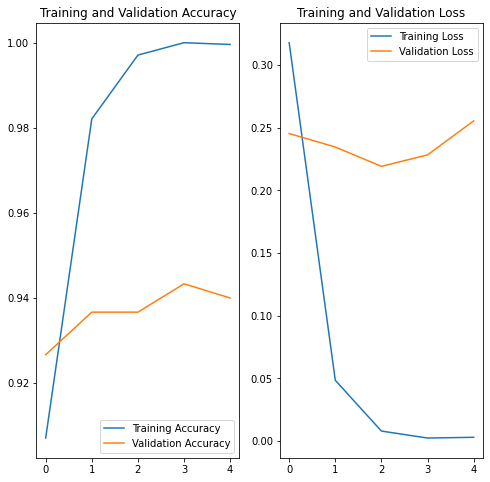

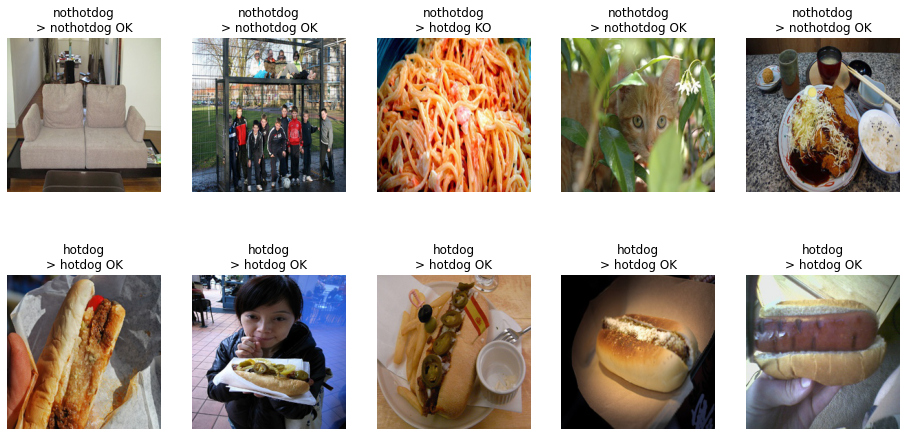


OKs : 9 KOs : 1 Pourcentage OK : 90 %


In [14]:
show_perfs(history, nb_epochs)
test_model(model)